In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns; sns.set()

import os 

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/ccorbin/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'mining-clinical-decisions' 
%load_ext google.cloud.bigquery

from google.cloud import bigquery
client=bigquery.Client()

%matplotlib inline

/share/sw/open/anaconda/3/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/share/sw/open/anaconda/3/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com

### Load in MultiLabel Cohort

In [2]:
q_cohort = """select * from traige_TE.triage_cohort_adjusted_multilabel"""
query_job = client.query(q_cohort)
df_cohort = query_job.result().to_dataframe()

In [3]:
df_cohort.head()

,jc_uid,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_24hr,label_12hr,acute_to_critical_24hr,acute_to_critical_12hr
0,JCcb658e,131231466934,24822070.0,2017-06-24 12:56:00+00:00,0,0,0,0
1,JCcb65bd,131072545278,14327919.0,2015-02-18 05:24:00+00:00,0,0,0,0
2,JCcb65e1,131239638605,26535361.0,2017-11-08 09:51:00+00:00,0,0,0,0
3,JCcb6601,131125490360,16936826.0,2015-09-15 02:57:00+00:00,0,0,0,0
4,JCcb681b,131179908684,18823433.0,2016-04-04 19:23:00+00:00,0,0,0,0


In [4]:
df_cohort[['label_24hr', 'label_12hr', 'acute_to_critical_24hr', 'acute_to_critical_12hr']].sum()

label_24hr                4591
label_12hr                4341
acute_to_critical_24hr     820
acute_to_critical_12hr     573
dtype: int64

### Load in Predictions From LGBM

In [5]:
df_preds_full = pd.read_csv('/home/ccorbin/triage_models/lightgbm/test_yhats.csv')
df_preds_simple = pd.read_csv('/home/ccorbin/BMI212/notebooks/results_gmb.csv')

In [6]:
print(df_preds_full.shape)
print(df_preds_simple.shape)

(9688, 4)
(6769, 4)


In [28]:
df_preds_simple = df_preds_simple.rename(columns={'preds_gbm' : 'predictions'})

In [29]:
df_preds_full = df_preds_full[['pat_enc_csn_id_coded', 'label', 'predictions']]
df_preds_simple = df_preds_simple[['pat_enc_csn_id_coded', 'label', 'predictions']]

In [30]:
df_preds_full.head()

,pat_enc_csn_id_coded,label,predictions
0,131255372082,0,0.597036
1,131256483898,0,0.024847
2,131254267620,0,0.060149
3,131257393135,0,0.069481
4,131256174910,0,0.051674


In [31]:
df_preds_full = pd.merge(df_preds_full, df_cohort, on='pat_enc_csn_id_coded', how='left')
df_preds_simple = pd.merge(df_preds_simple, df_cohort, on='pat_enc_csn_id_coded', how='left')

In [10]:
df_preds_full.head()

# for i in range(len(df_preds)):
#     assert df_preds['label'].values[i] == df_preds['label_24hr'].values[i]

,pat_enc_csn_id_coded,label,predictions,jc_uid,inpatient_data_id_coded,admit_time,label_24hr,label_12hr,acute_to_critical_24hr,acute_to_critical_12hr
0,131255372082,0,0.597036,JCcb6fa2,31538652.0,2018-08-23 00:19:00+00:00,0,0,0,0
1,131256483898,0,0.024847,JCcb6fd0,31878212.0,2018-08-29 00:22:00+00:00,0,0,0,0
2,131254267620,0,0.060149,JCcb7083,31146723.0,2018-08-18 01:47:00+00:00,0,0,0,0
3,131257393135,0,0.069481,JCcb723a,32132242.0,2018-09-16 00:01:00+00:00,0,0,0,0
4,131256174910,0,0.051674,JCcb73e3,31768064.0,2018-09-25 14:15:00+00:00,0,0,0,0


### Get list of patient ids that were used for training

In [11]:
training_jc_uids = set(df_cohort[df_cohort['admit_time'] < '2017-07-01']['jc_uid'].values)
test_jc_uids = set(df_preds_full['jc_uid'].values)
seen_jc_uids = training_jc_uids.intersection(test_jc_uids)

df_preds_unseen = df_preds_full[~df_preds_full['jc_uid'].isin(seen_jc_uids)]

# Sanity Check
for i in range(len(df_preds_unseen)):
    assert df_preds_unseen['jc_uid'].values[i] not in training_jc_uids

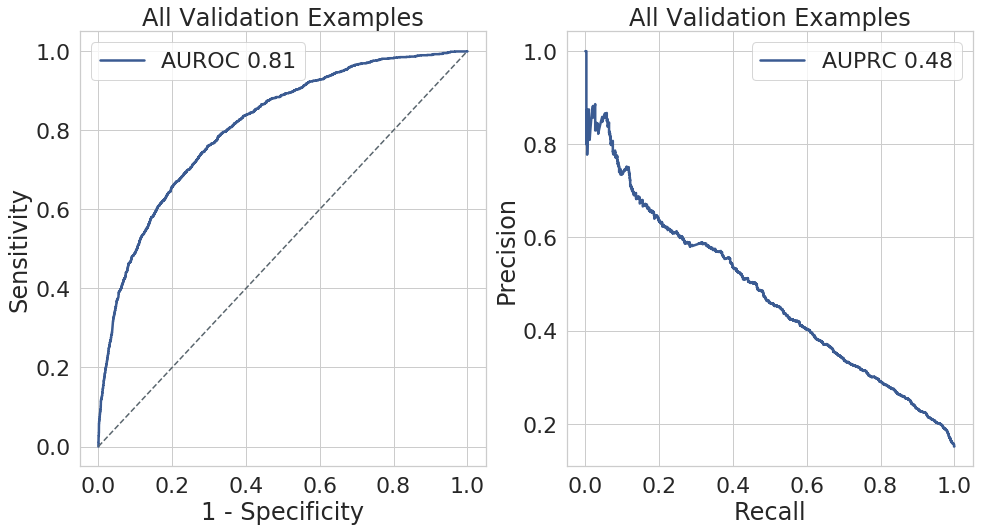

In [16]:
import pdb

def plot_perf(labels, predictions, title):
    # Plots ROC AND PRC side by side
    sns.set(font_scale=2.)
    sns.set_style("whitegrid")
    fig1 = plt.figure(figsize=(16, 8))

    ax1 = fig1.add_subplot(1, 2, 1)


    tpr, fpr, _ = roc_curve(labels, predictions)
    auroc = roc_auc_score(labels, predictions)

    ax1.plot(tpr, fpr, sns.xkcd_rgb["denim blue"], lw=2.5, label = 'AUROC %.2f' % auroc )
    ax1.plot([0, 1],
             [0, 1],
             sns.xkcd_rgb["slate grey"],
            lw=1.5, linestyle='--')
    
    ax1.set_ylabel('Sensitivity')
    ax1.set_xlabel('1 - Specificity')
    ax1.set_title(title)
    ax1.legend()
    ax1.plot()
    
    ax2 = fig1.add_subplot(1, 2, 2)

    precision, recall, _ = precision_recall_curve(labels, predictions)
    auprc = average_precision_score(labels, predictions)

    ax2.plot(recall, precision, sns.xkcd_rgb["denim blue"], lw=2.5, label = 'AUPRC %.2f' % auprc)
    
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Recall')
    ax2.set_title(title)
    ax2.legend()
    ax2.plot()
    

plot_perf(df_preds_full['label'], df_preds_full['predictions'], 'All Validation Examples')


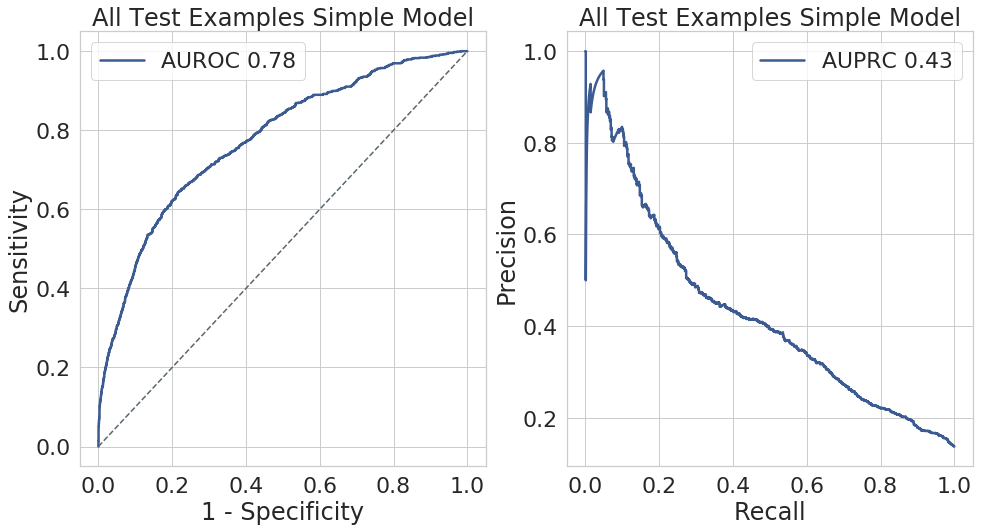

In [32]:
plot_perf(df_preds_simple['label'], df_preds_simple['predictions'], 'All Test Examples Simple Model')


In [24]:
# Get prob thresh 
precision, recall, p_thresh = precision_recall_curve(df_preds_full['label'], df_preds_full['predictions'])
def get_index_at_recall(val):
    for i, rec in enumerate(recall):
        if rec < val:
            return i-1
    return None

print(p_thresh[get_index_at_recall(0.8)])

0.0997845793941084


### Plot Performance For Patients that Were Not Seen In Training

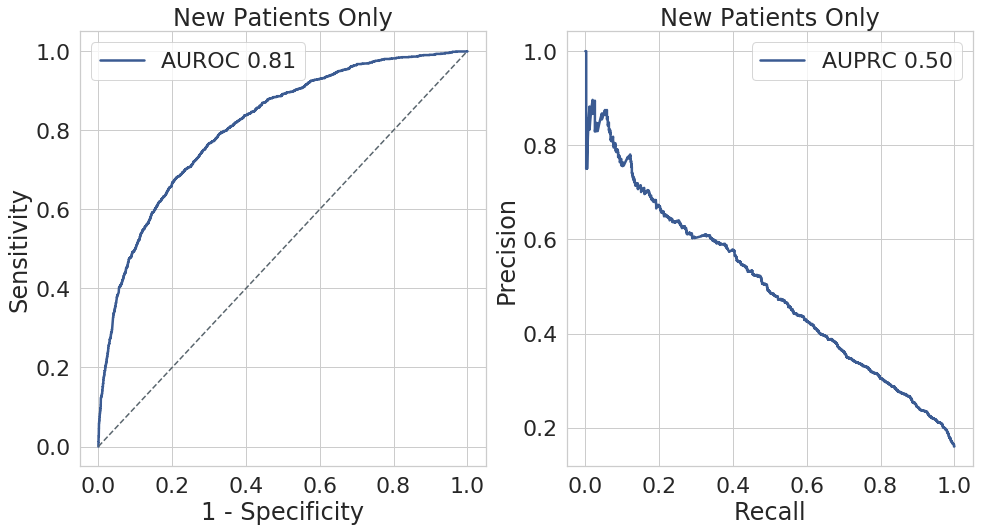

In [13]:
plot_perf(df_preds_unseen['label'], df_preds_unseen['predictions'], 'New Patients Only')


### Plot Performance Where Labels are 0 if acute care only and 1 if moved TO ICU within 24 hours

In [59]:
df_preds_move = df_preds[(df_preds['label'] == 0) | (df_preds['acute_to_critical_24hr']  == 1)]

In [61]:
df_preds_move.head()

,pat_enc_csn_id_coded,label,predictions,jc_uid,inpatient_data_id_coded,admit_time,label_24hr,label_12hr,acute_to_critical_24hr,acute_to_critical_12hr
0,131239638605,0,0.308101,JCcb65e1,26535361.0,2017-11-08 09:51:00+00:00,0,0,0,0
1,131242040499,0,0.314080,JCcb6a76,27519394.0,2017-11-03 06:00:00+00:00,0,0,0,0
2,131236401375,0,0.150636,JCcb6f63,25417945.0,2017-07-30 19:49:00+00:00,0,0,0,0
3,131236120805,0,0.039077,JCcb774e,25310954.0,2017-07-16 13:50:00+00:00,0,0,0,0
4,131238175137,0,0.090910,JCcb774e,26080150.0,2017-09-14 09:07:00+00:00,0,0,0,0


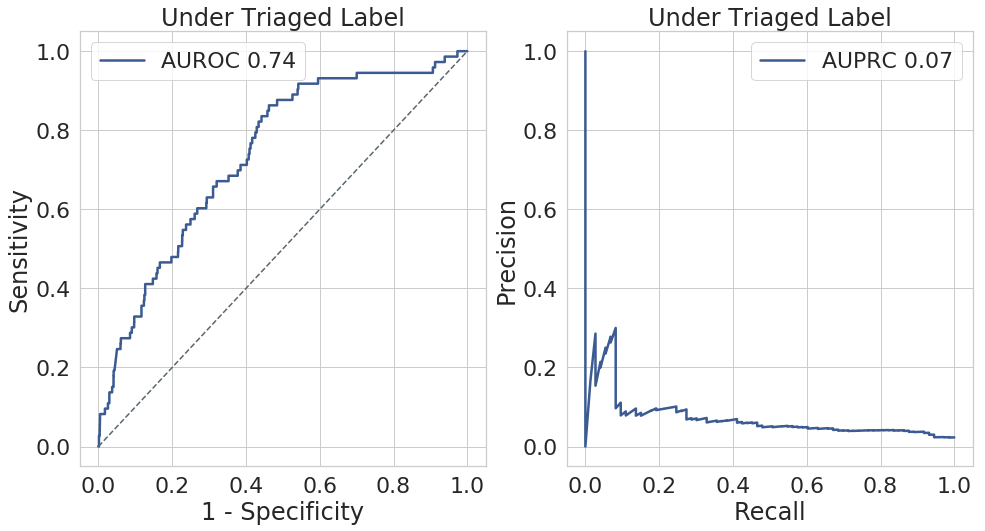

In [65]:
plot_perf(df_preds_move['label'], df_preds_move['predictions'], 'Under Triaged Label')


In [66]:
74/len(df_preds_move)

0.02282541640962369

### Now Get Sensitivity and Specificity Cutoff For Doctors Assuming 24 hours after is correct label

In [67]:
from sklearn.metrics import classification_report

In [68]:
df_preds.sum()

pat_enc_csn_id_coded                                         479810980526266
label                                                                    487
predictions                                                          481.124
jc_uid                     JCcb65e1JCcb6a76JCcb6f63JCcb774eJCcb774eJCcb7b...
inpatient_data_id_coded                                          9.68093e+10
label_24hr                                                               487
label_12hr                                                               468
acute_to_critical_24hr                                                    73
acute_to_critical_12hr                                                    54
dtype: object

In [69]:
df_preds['init_assignmet'] = df_preds.apply(lambda x: 1 if x.label_24hr and not x.acute_to_critical_24hr else 0, axis=1)

In [70]:
df_preds.sum()

pat_enc_csn_id_coded                                         479810980526266
label                                                                    487
predictions                                                          481.124
jc_uid                     JCcb65e1JCcb6a76JCcb6f63JCcb774eJCcb774eJCcb7b...
inpatient_data_id_coded                                          9.68093e+10
label_24hr                                                               487
label_12hr                                                               468
acute_to_critical_24hr                                                    73
acute_to_critical_12hr                                                    54
init_assignmet                                                           414
dtype: object

In [72]:
print(classification_report(df_preds['label_24hr'], df_preds['init_assignmet']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3169
           1       1.00      0.85      0.92       487

   micro avg       0.98      0.98      0.98      3656
   macro avg       0.99      0.93      0.95      3656
weighted avg       0.98      0.98      0.98      3656



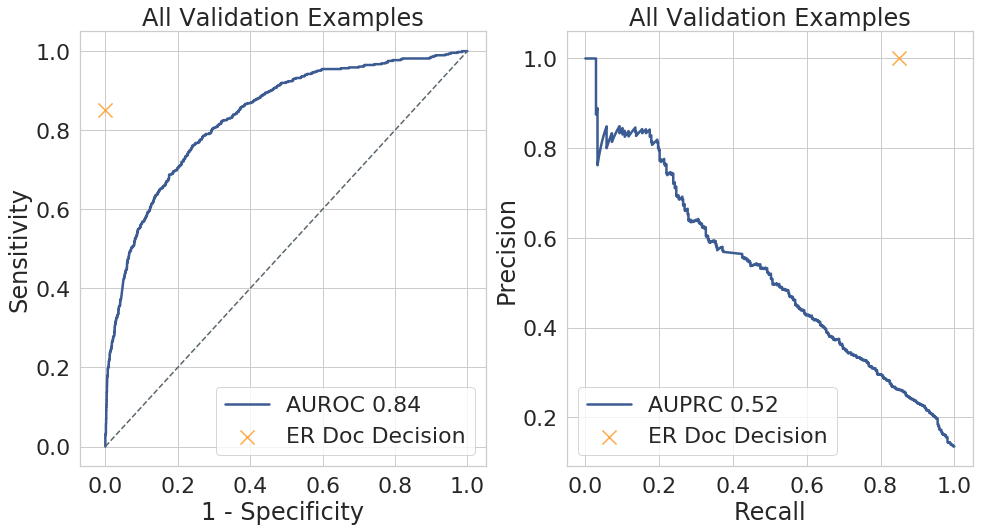

In [81]:
def plot_perf_with_marker(labels, predictions, title):
    # Plots ROC AND PRC side by side
    sns.set(font_scale=2.)
    sns.set_style("whitegrid")
    fig1 = plt.figure(figsize=(16, 8))

    ax1 = fig1.add_subplot(1, 2, 1)


    tpr, fpr, _ = roc_curve(labels, predictions)
    auroc = roc_auc_score(labels, predictions)

    ax1.plot(tpr, fpr, sns.xkcd_rgb["denim blue"], lw=2.5, label = 'AUROC %.2f' % auroc )
    ax1.plot([0, 1],
             [0, 1],
             sns.xkcd_rgb["slate grey"],
            lw=1.5, linestyle='--')
    
    ax1.scatter(np.array([0]), np.array([0.85]), marker='x', s=200, color=sns.xkcd_rgb['light orange'], label = 'ER Doc Decision')
    ax1.set_ylabel('Sensitivity')
    ax1.set_xlabel('1 - Specificity')
    ax1.set_title(title)
    ax1.legend()
    ax1.plot()
    
    
    ax2 = fig1.add_subplot(1, 2, 2)

    precision, recall, _ = precision_recall_curve(labels, predictions)
    auprc = average_precision_score(labels, predictions)
    ax2.scatter(np.array([0.85]), np.array([1]), marker='x', s=200, color=sns.xkcd_rgb['light orange'], label = 'ER Doc Decision')

    ax2.plot(recall, precision, sns.xkcd_rgb["denim blue"], lw=2.5, label = 'AUPRC %.2f' % auprc)
    
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Recall')
    ax2.set_title(title)
    ax2.legend()
    ax2.plot()
    

plot_perf_with_marker(df_preds['label'], df_preds['predictions'], 'All Validation Examples')
